In [1]:
import pandas as pd
from datetime import datetime

## Read training and test datasets

In [2]:
# helper function for reading datatset
def read_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # convert it to datatime

    return df

In [3]:
df_train = read_data('data/kospi_train.csv')
df_test = read_data('data/kospi_test.csv')

len(df_train), len(df_test)

(986, 244)

In [4]:
# the training dataset has daily KOSPI index from 2019 to 2022
df_train

,Date,Open,Low,High,Close,Volume
0,2019-01-02,2050.550049,2004.270020,2053.449951,2010.000000,326400
1,2019-01-03,2011.810059,1991.650024,2014.719971,1993.699951,428000
2,2019-01-04,1992.400024,1984.530029,2011.560059,2010.250000,409000
3,2019-01-07,2034.239990,2030.900024,2048.060059,2037.099976,440200
4,2019-01-08,2038.680054,2023.589966,2042.699951,2025.270020,397800
...,...,...,...,...,...,...
981,2022-12-23,2325.860107,2311.899902,2333.080078,2313.689941,367000
982,2022-12-26,2312.540039,2304.199951,2321.919922,2317.139893,427600
983,2022-12-27,2327.520020,2321.479980,2335.989990,2332.790039,448300
984,2022-12-28,2296.449951,2276.899902,2296.449951,2280.449951,405700


In [5]:
# the test dataset has daily KOSPI index in 2023
df_test

,Date,Open,Low,High,Close,Volume
0,2023-01-02,2249.949951,2222.370117,2259.879883,2225.669922,346100
1,2023-01-03,2230.979980,2180.669922,2230.979980,2218.679932,410000
2,2023-01-04,2205.979980,2198.820068,2260.060059,2255.979980,412700
3,2023-01-05,2268.199951,2252.969971,2281.389893,2264.649902,430800
4,2023-01-06,2253.399902,2253.270020,2300.620117,2289.969971,398300
...,...,...,...,...,...,...
239,2023-12-21,2598.370117,2587.159912,2610.810059,2600.020020,578300
240,2023-12-22,2617.719971,2599.510010,2621.370117,2599.510010,466000
241,2023-12-26,2609.439941,2594.649902,2612.139893,2602.590088,439500
242,2023-12-27,2599.350098,2590.080078,2613.500000,2613.500000,349700


## Part 1. Train regression models to predict the next day's `close` using `Open`, `Low`, `High`, `Close`, `Volume` of previous days as predictors using *only* df_train. Cross-validate to select the best model. Evaluate the accuracy of your model using `df_test`.



교차 검증 결과:

Linear Regression:
MSE: 131.3470
RMSE: 11.1315
MAE: 8.4544
R2: 0.9897

Random Forest:
MSE: 22561.5133
RMSE: 123.1384
MAE: 87.5691
R2: -0.6000

XGBoost:
MSE: 21545.2673
RMSE: 116.4313
MAE: 82.9133
R2: -0.4326

테스트 결과 (Linear Regression):
MSE: 59.7133
RMSE: 7.7274
MAE: 5.8638
R2: 0.9911


C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\1505479517.py:103: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing fro

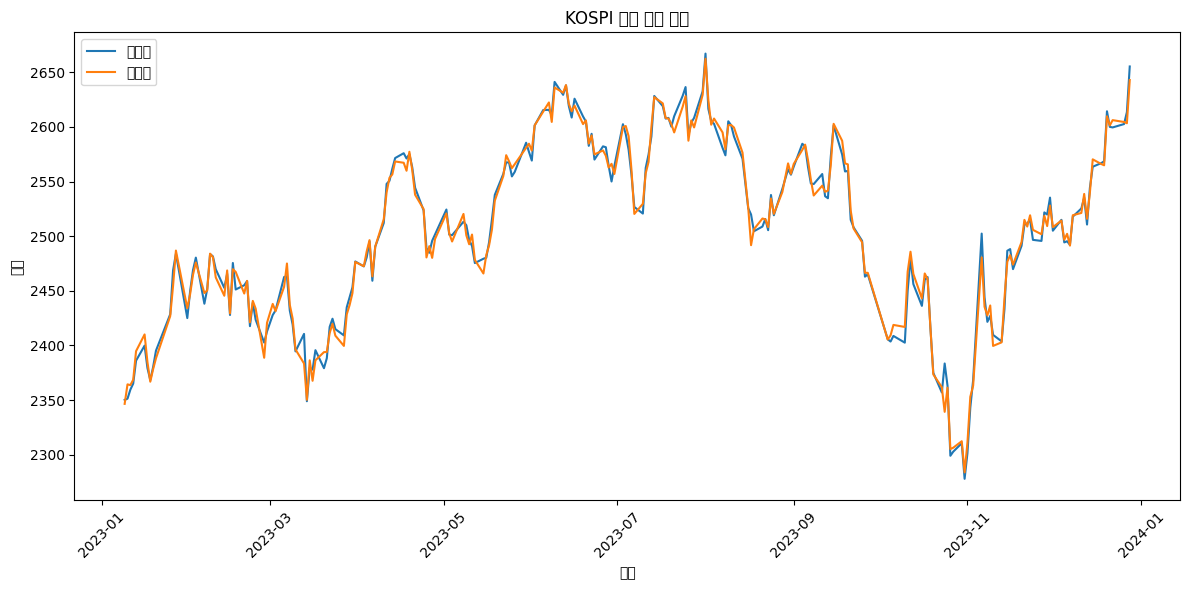

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def create_features(df, target_col='Close', n_steps=5):
    df = df.copy()
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps + 1):
        for col in ['Open', 'Low', 'High', 'Close', 'Volume']:
            df[f'{col}_lag_{i}'] = df[col].shift(i)
    
    df.dropna(inplace=True)
    
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols]
    y = df[target_col]
    
    return X, y

def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'MAE': mae,
        'R2': r2
    }

X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)

tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

cv_results = {}
for name, model in models.items():
    scores = []
    for train_idx, val_idx in tscv.split(X_train_scaled):
        X_train_cv = X_train_scaled[train_idx]
        y_train_cv = y_train.iloc[train_idx]
        X_val_cv = X_train_scaled[val_idx]
        y_val_cv = y_train.iloc[val_idx]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        scores.append(evaluate_model(y_val_cv, y_pred_cv))
    
    cv_results[name] = {
        'MSE': np.mean([score['MSE'] for score in scores]),
        'RMSE': np.mean([score['RMSE'] for score in scores]),
        'MAE': np.mean([score['MAE'] for score in scores]),
        'R2': np.mean([score['R2'] for score in scores])
    }

print("\n교차 검증 결과:")
for name, scores in cv_results.items():
    print(f"\n{name}:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

best_model_name = min(cv_results.items(), key=lambda x: x[1]['RMSE'])[0]
best_model = models[best_model_name]

best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

test_results_part1 = evaluate_model(y_test, y_pred)
print(f"\n테스트 결과 ({best_model_name}):")
for metric, value in test_results_part1.items():
    print(f"{metric}: {value:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='실제값')
plt.plot(y_test.index, y_pred, label='예측값')
plt.title('KOSPI 종가 예측 결과')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()

## Part 2. Extend the regression model by adding some extra features of your choice. You can use any statistics publicly available. 


교차 검증 결과:

Random Forest:
MSE: 21938.4001
RMSE: 117.5827
MAE: 77.2106
R2: 0.2612

XGBoost:
MSE: 27114.9173
RMSE: 128.1392
MAE: 89.8060
R2: -0.3987

테스트 결과 (Random Forest):
MSE: 152.4339
RMSE: 12.3464
MAE: 9.5911
R2: 0.9756


C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\devap\AppData\Local\Temp\ipykernel_4164\2673094879.py:160: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing fro

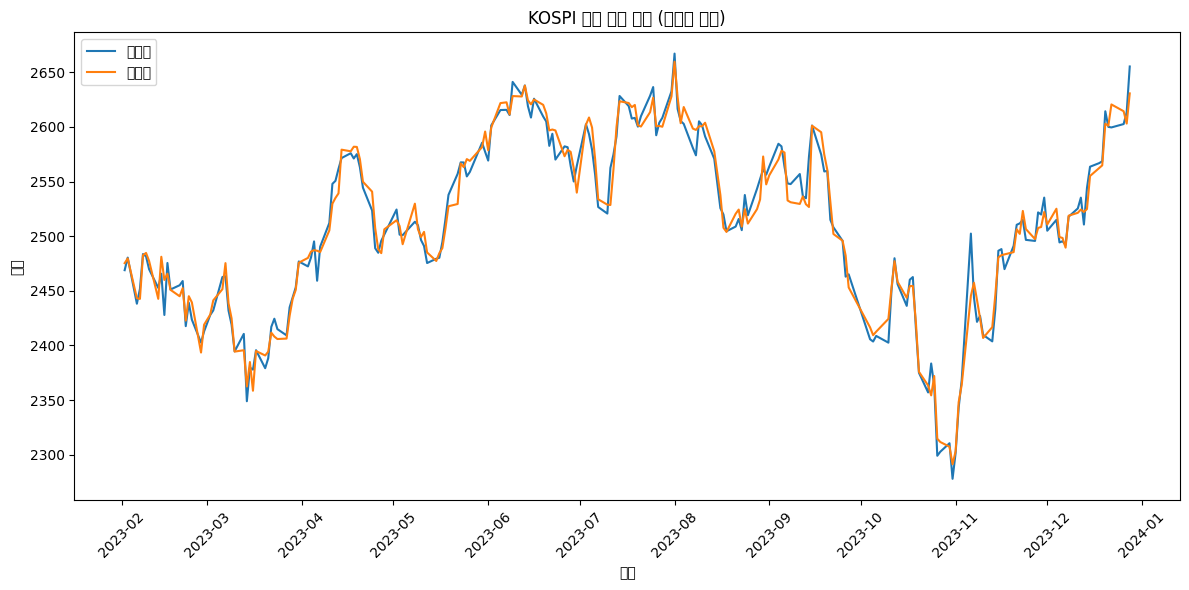

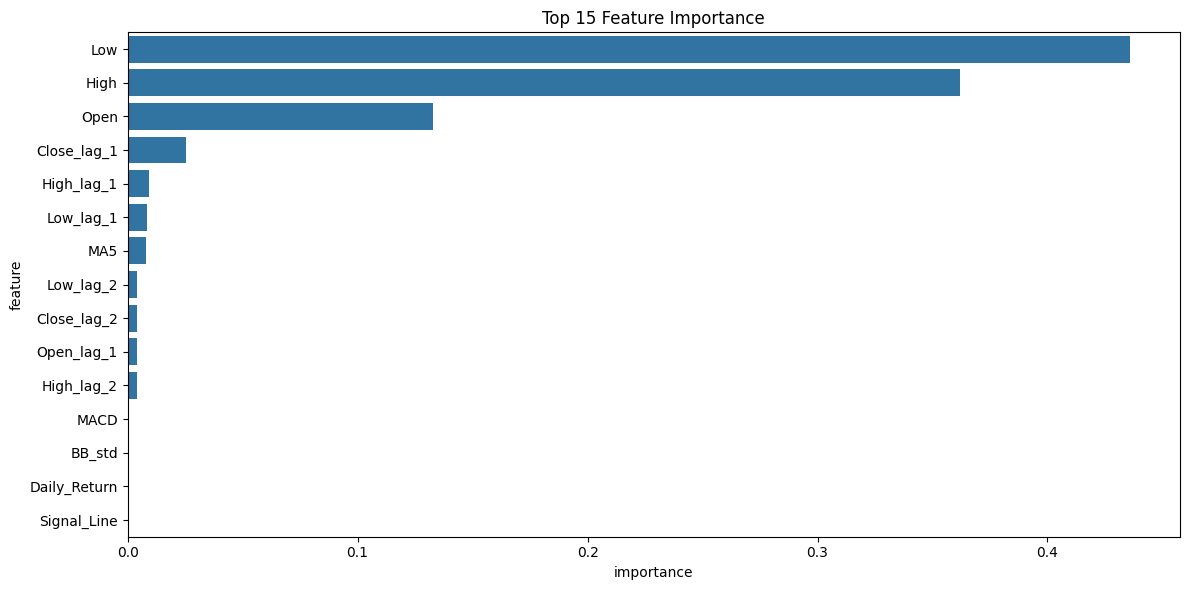


Part 1과 Part 2의 성능 비교:
Part 1 (기본 특성):
MSE: 59.7133
RMSE: 7.7274
MAE: 5.8638
R2: 0.9911

Part 2 (향상된 특성):
MSE: 152.4339
RMSE: 12.3464
MAE: 9.5911
R2: 0.9756


In [8]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def add_technical_indicators(df):
    df = df.copy()
    
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
    
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    df['Price_Range'] = df['High'] - df['Low']
    
    for i in range(1, 6):
        for col in ['Open', 'Low', 'High', 'Close', 'Volume']:
            df[f'{col}_lag_{i}'] = df[col].shift(i)
    
    df.dropna(inplace=True)
    
    return df

def prepare_data(df):
    df.set_index('Date', inplace=True)
    
    feature_cols = [col for col in df.columns if col != 'Close']
    X = df[feature_cols]
    y = df['Close']
    
    return X, y

df_train_enhanced = add_technical_indicators(df_train)
df_test_enhanced = add_technical_indicators(df_test)

X_train, y_train = prepare_data(df_train_enhanced)
X_test, y_test = prepare_data(df_test_enhanced)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, random_state=42)
}

cv_results = {}
for name, model in models.items():
    scores = []
    for train_idx, val_idx in tscv.split(X_train_scaled):
        X_train_cv = X_train_scaled[train_idx]
        y_train_cv = y_train.iloc[train_idx]
        X_val_cv = X_train_scaled[val_idx]
        y_val_cv = y_train.iloc[val_idx]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        scores.append({
            'MSE': mean_squared_error(y_val_cv, y_pred_cv),
            'RMSE': np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)),
            'MAE': mean_absolute_error(y_val_cv, y_pred_cv),
            'R2': r2_score(y_val_cv, y_pred_cv)
        })
    
    cv_results[name] = {
        'MSE': np.mean([score['MSE'] for score in scores]),
        'RMSE': np.mean([score['RMSE'] for score in scores]),
        'MAE': np.mean([score['MAE'] for score in scores]),
        'R2': np.mean([score['R2'] for score in scores])
    }

print("\n교차 검증 결과:")
for name, scores in cv_results.items():
    print(f"\n{name}:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

best_model_name = min(cv_results.items(), key=lambda x: x[1]['RMSE'])[0]
best_model = models[best_model_name]

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

test_results = {
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

print(f"\n테스트 결과 ({best_model_name}):")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='실제값')
plt.plot(y_test.index, y_pred, label='예측값')
plt.title('KOSPI 종가 예측 결과 (향상된 모델)')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

print("\nPart 1과 Part 2의 성능 비교:")
print("Part 1 (기본 특성):")
for metric, value in test_results_part1.items():
    print(f"{metric}: {value:.4f}")
print("\nPart 2 (향상된 특성):")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")